# Atividade Prática 4

## Classificação do Dataset Iris

In [1]:
# Inicialmente carrega-se as bibliotecas necessárias

from matplotlib import pyplot as plt
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.io import loadmat

import torch
from torch.utils.data import TensorDataset, DataLoader

import anfis
from membership import GaussMembFunc, make_gauss_mfs
from experimental import train_anfis, test_anfis

from cmenas import cmenas
from norm import normalize, denormalize

from sklearn.model_selection import KFold

In [2]:
# Define-se o tipo de dados dos tensores 
dtype = torch.float

In [3]:
# Define-se o método de carregamento dos dados

def data(partition=None, forced_idx=None):
    # loading data set
    data = pd.read_csv('data/iris.csv').dropna().drop(columns = ['Id'])

    data = data.to_numpy()
    length = len(data)

    # 70 / 30

    if partition is not None:
        idx = np.arange(length)
        np.random.seed(4225)
        np.random.shuffle(idx)

        eta = 0.7

        if partition == 'train':
            idx = idx[:int(eta * length)]
        if partition == 'test':
            idx = idx[int(eta * length):]

    if forced_idx is not None:
        idx = forced_idx

    data[data[:, data.shape[1] - 1] != 'Iris-setosa', data.shape[1]- 1] = 1
    data[data[:, data.shape[1] - 1] == 'Iris-setosa', data.shape[1]- 1] = -1

    x = torch.zeros((len(idx), data.shape[1] - 1))
    y = torch.zeros((len(idx), 1))
    for i, index in enumerate(idx):
        x[i, 0] = torch.tensor(data[index, 0])
        x[i, 1] = torch.tensor(data[index, 1])
        x[i, 2] = torch.tensor(data[index, 2])
        x[i, 3] = torch.tensor(data[index, 3])
        y[i, 0] = torch.tensor(data[index, 4])

    td = TensorDataset(x, y)
    return DataLoader(td, batch_size = 1024, shuffle = True), idx

In [4]:
# Define-se a criação do modelo

def model(data, n_rules):

    # numpy and norm
    x, y = data.dataset.tensors
    x = x.numpy()
    x, minimum, maximum = normalize(data = x)

    # cmeans
    # como o numero de entradas é constante n de regras = n de funcoes de
    # pertinencia = numero de centros

    modelo = cmenas(k = n_rules)
    modelo.train(data = x, MAX = 15, tol = 1e-2)
    centros = modelo.C

    # denorm
    centros = denormalize(data = centros, m = minimum, M = maximum)

    def mk_var(name, centros, i):
        return (name, make_gauss_mfs(1, [centros[n, i] for n in range(n_rules)]))

    invardefs = [mk_var(name, centros, i) for i, name in
                 enumerate(['SepalLengthCm', 'SepalWidthCm',
                  'PetalLengthCm', 'PetalWidthCm'])]

    outvars = ['Species']

    model = anfis.AnfisNet('iris', invardefs, outvars)
    return model

Note que pelo fato do número de entradas ser constante o número de regras está em função exclusivamente do número de fuções de pertinência associado a cada entrada. Ao usar o algoritmo cmeans para determinar o centro das funções gaussianas de pertinência o número de clusters corresponde diretamente ao número de funções de pertinência e portanto ao número de regras.

A variância das funções de pertinência é definida manualmente devido à sensibilidade do algoritmo de aprendizado híbrido a seu valor.

In [5]:
# Define-se procedimento de divisão dos dados de treinamento em kfolds

def kfold_data(idx, k=10): #assume indices preprocessados

    kfold = KFold(k)
    folds = []

    for i, (train, test) in enumerate(kfold.split(idx)):

        train_data, _ = data(forced_idx = train)
        test_data, _ = data(forced_idx = test)
        folds.append({'train':train_data, 'test':test_data})

    return folds

A busca em grade é feita para determinar o valor ótimo de regras para o sistema. Como o treinamento passa a ficar muito demorado com mais do que cinco regras o espaço da busca é limitado, para fins de demonstração, a esse valor. Os modelos são avaliados de acordo com o algoritmo de kfolds e a acurácia média de cada regra é registrada para que o número de regras que obteve a maior acurácia seja selecionado. Por mim o modelo vencedor é usado para classificar o conjunto de testes. Esse é o resultado visualizado.

1 loss: 33.689517283652094 duration: 0.0001380443572998047
2 loss: 23.563892337617656 duration: 0.00011038780212402344
3 loss: 23.563892337617656 duration: 9.870529174804688e-05
1 loss: 48.774444498571484 duration: 0.0001232624053955078
2 loss: 24.293142416403274 duration: 0.00010991096496582031
3 loss: 24.293142416403274 duration: 9.918212890625e-05
1 loss: 42.94532844004016 duration: 0.00012087821960449219
2 loss: 24.281743805710907 duration: 0.00010991096496582031
3 loss: 24.281743805710907 duration: 9.775161743164062e-05
1 loss: 52.79379415595031 duration: 0.00012946128845214844
2 loss: 23.32766412972327 duration: 0.00011897087097167969
3 loss: 23.32766412972327 duration: 0.00010347366333007812
1 loss: 46.132064358482694 duration: 0.0001556873321533203
2 loss: 23.51414091527264 duration: 0.00016951560974121094
3 loss: 23.51414091527264 duration: 0.000141143798828125
1 loss: 44.31109968075998 duration: 0.00014734268188476562
2 loss: 25.24614387523594 duration: 0.000110626220703125
3

1 loss: 14.132575622653732 duration: 0.0001976490020751953
2 loss: 8.528300831668576 duration: 0.0003173351287841797
3 loss: 6.9844275816909605 duration: 0.0013675689697265625
4 loss: 4.327731478305995 duration: 0.00039958953857421875
5 loss: 3.889031599781648 duration: 0.00038313865661621094
6 loss: 3.841500652156332 duration: 0.0016787052154541016
7 loss: 3.8005505668354913 duration: 0.0001914501190185547
8 loss: 3.7239644841074497 duration: 0.00018024444580078125
9 loss: 3.6252193772772228 duration: 0.00017714500427246094
10 loss: 3.58387428342868 duration: 0.00017595291137695312
11 loss: 3.576110031427807 duration: 0.00021386146545410156
1 loss: 4.930366082452542 duration: 0.0003631114959716797
2 loss: 3.4293561315735683 duration: 0.001001119613647461
3 loss: 3.3181386838324416 duration: 0.00022101402282714844
4 loss: 3.3060390957551413 duration: 0.0002663135528564453
5 loss: 3.304899452775718 duration: 0.00018525123596191406
1 loss: 3.3127904225505196 duration: 0.00048375129699707

1 loss: 2.4704179211206703 duration: 0.0002942085266113281
2 loss: 1.8074357843930178 duration: 0.0003032684326171875
3 loss: 1.7647964265213103 duration: 0.0013577938079833984
4 loss: 1.7486994474610833 duration: 0.0007243156433105469
5 loss: 1.742898386304773 duration: 0.0003788471221923828
1 loss: 2.237894770309001 duration: 0.0003139972686767578
2 loss: 1.7598826699446448 duration: 0.000946044921875
3 loss: 1.7043060294465535 duration: 0.0006153583526611328
4 loss: 1.6872547473597703 duration: 0.0006139278411865234
5 loss: 1.6754905972643068 duration: 0.00033974647521972656
6 loss: 1.6577197806000377 duration: 0.0013124942779541016
7 loss: 1.6371095090499401 duration: 0.0010042190551757812
8 loss: 1.6247544762635076 duration: 0.000989675521850586
9 loss: 1.6198950272019448 duration: 0.0009257793426513672
1 loss: 94.67426569508552 duration: 0.00015401840209960938
2 loss: 28.36235417987415 duration: 0.00014400482177734375
3 loss: 28.36235417987415 duration: 0.0001285076141357422


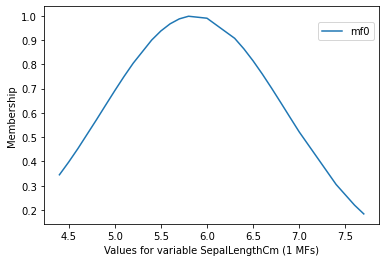

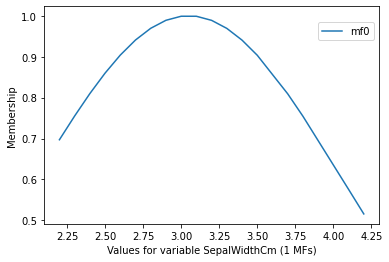

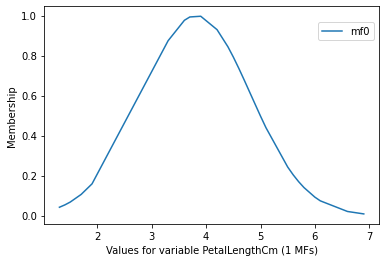

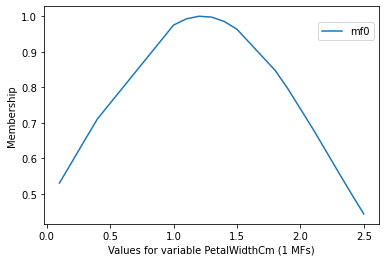

### Testing for 45 cases


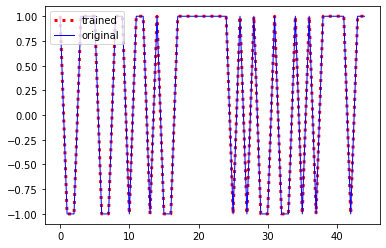

erro percentual =0.00%


In [6]:
# particao de train é usada para k folds

train_data, idx = data(partition = 'train')
folds = kfold_data(idx)

rule_range = range(5) # range de busca do grid search
fold_eval = np.zeros((len(rule_range), len(folds)))

for r, n_rules in enumerate(rule_range):
    for f, fold in enumerate(folds):
        fold_train_data = fold['train']
        fold_test_data = fold['test']
        anfis_model = model(fold_train_data, n_rules + 1)
        train_anfis(anfis_model, data = fold_train_data, epochs = 20, show_plots = False)
        _, _, perc_loss = test_anfis(anfis_model, data = fold_test_data, show_plots = False)
        fold_eval[r, f] = perc_loss

# particao de teste é avaliada com os parametros determinados

best_n_rule = np.argmin(np.mean(fold_eval, axis=1)) + 1

anfis_model = model(train_data, best_n_rule)
train_anfis(anfis_model, data = train_data, epochs = 20, show_plots = False)
test_data, _ = data(partition = 'test')
_, _, error = test_anfis(anfis_model, data = test_data, show_plots = True)
print('erro percentual ={:.2f}%'.format(error))

Também não foi possível mostrar uma curva de *underfitting* e *overfitting* já que o modelo não errou em nenhuma iteração no conjunto de teste, constante para o número de regras.

In [7]:
print(fold_eval)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Classificação da base Breast Cancer

A classificação da base Wisconsin Breast Cancer foi feita de maneira quase exatamente análoga. A primeira observação relevante é que os dados fornecidos para o trabalho geraram problemas de memória devido ao alto número de características. Usou-se portanto a versão reduzida em features da base disponível em https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

In [8]:
# Redefine-se uma rotina de carregamento dos dados

def data(partition=None, matlab=False, forced_idx=None):
    # loading data set
    data = pd.read_csv('data/wdbc.data')
    data = data.drop(columns = data.columns[0])
    # 70 / 30
    data = data.to_numpy()
    length = len(data)
    idx = np.arange(length)
    np.random.shuffle(idx)

    if partition is not None:
        idx = np.arange(length)
        np.random.seed(4224)
        np.random.shuffle(idx)

        eta = 0.7

        if partition == 'train':
            idx = idx[:int(eta * length)]
        if partition == 'test':
            idx = idx[int(eta * length):]

    if forced_idx is not None:
        idx = forced_idx

    # x, y
    if matlab:
        x = data[idx, 1:data.shape[1]]
        y = data[idx, 0]
        y[y == 'B'] = -1
        y[y == 'M'] = 1
        data[idx, 0] = y
    else:
        x = data[idx, :-1]
        y = data[idx, -1]
        y[y == 4] = -1
        y[y == 2] = 1
        data[idx, 0] = y

    # torch
    x = torch.tensor(np.array(x, dtype = np.float))
    y = torch.tensor(np.array(y, dtype = np.float))

    # copiei do anterior pq acima deu problema de float / double

    x = torch.zeros((len(idx), data.shape[1] - 1))
    y = torch.zeros((len(idx), 1))
    for i, index in enumerate(idx):
        for n_feature in range(data.shape[1] - 1):
            x[i, n_feature] = torch.tensor(data[index, n_feature + 1])

        y[i, 0] = torch.tensor(data[index, 0])

    td = TensorDataset(x, y)
    return DataLoader(td, batch_size = 1024, shuffle = True), idx


In [9]:
# Redefine-se uma rotina de criação do modelo

def model(data, n_rules):

    # numpy and norm
    x, y = data.dataset.tensors
    y = y.float()
    x = x.numpy()
    x, minimum, maximum = normalize(data = x)
    x = x.astype(float)

    # cmeans
    # como o numero de entradas é constante n de regras = n de funcoes de
    # pertinencia = numero de centros

    modelo = cmenas(k = n_rules)
    modelo.train(data = x, MAX = 15, tol = 1e-2)
    centros = modelo.C

    # denorm
    centros = denormalize(data = centros, m = minimum, M = maximum)

    names = [
            'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
            'smoothness_mean', 'compactness_mean', 'concavity_mean' 'conc_mean',
             'points_mean', 'symmetry_mean']

    def mk_var(name, centros, i):
        return (name, make_gauss_mfs(3, [centros[n, i] for n in range(n_rules)]))

    invardefs = [mk_var(name, centros, i) for i, name in enumerate(names)]

    outvars = ['diagnosis']

    model = anfis.AnfisNet('breast-cancer', invardefs, outvars)
    return model

1 loss: 1131.7936026851205 duration: 0.0001430511474609375
2 loss: 460.0090999597968 duration: 0.0007243156433105469
3 loss: 460.0090999597968 duration: 0.0005977153778076172
1 loss: 616.9605509508372 duration: 0.00014901161193847656
2 loss: 456.1874648707226 duration: 0.00066375732421875
3 loss: 456.1874648707226 duration: 0.0006077289581298828
1 loss: 714.5265779193982 duration: 0.0002465248107910156
2 loss: 455.3626355184325 duration: 0.0007750988006591797
3 loss: 455.3626355184325 duration: 0.0006499290466308594
1 loss: 1694.6841518500703 duration: 0.00020766258239746094
2 loss: 445.28579854019756 duration: 0.0008542537689208984
3 loss: 445.28579854019756 duration: 0.0006070137023925781
1 loss: 647.31206307143 duration: 0.00014901161193847656
2 loss: 439.8553113795224 duration: 0.0006711483001708984
3 loss: 439.8553113795224 duration: 0.0009849071502685547
1 loss: 688.5819302783605 duration: 0.00014853477478027344
2 loss: 445.15428416235807 duration: 0.0009293556213378906
3 loss: 4

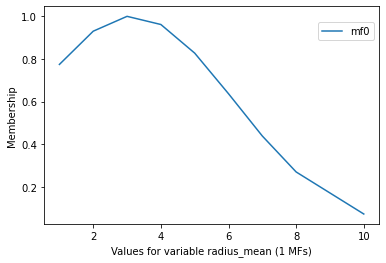

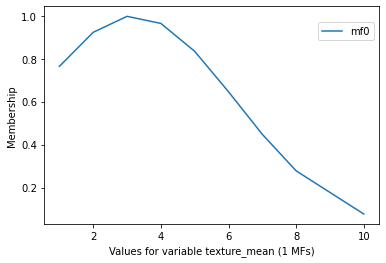

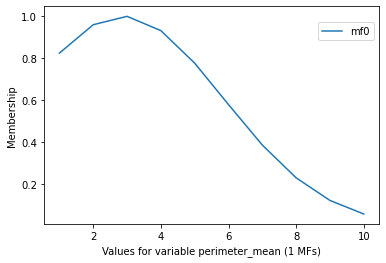

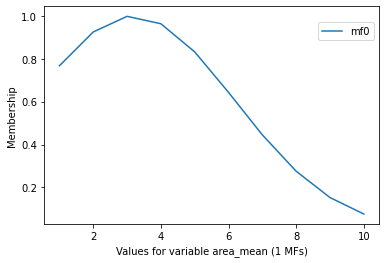

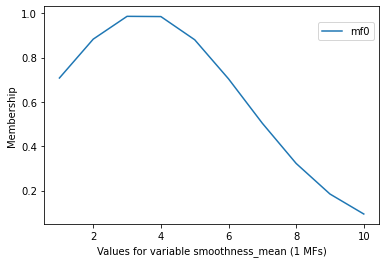

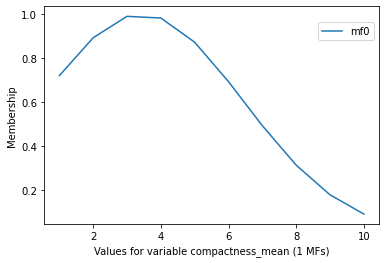

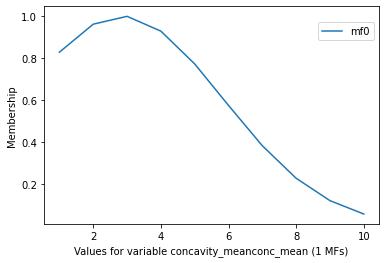

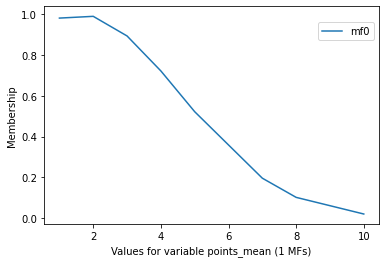

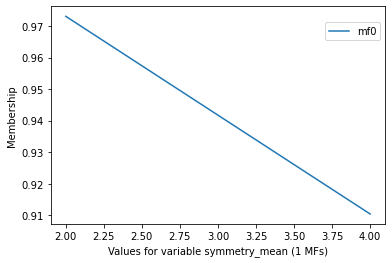

### Testing for 205 cases


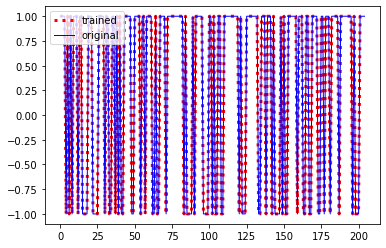

erro percentual =0.00%


In [10]:
train_data, idx = data(partition = 'train')
folds = kfold_data(idx)

rule_range = range(1)
fold_eval = np.zeros((len(rule_range), len(folds)))

for r, n_rules in enumerate(rule_range):
    for f, fold in enumerate(folds):
        fold_train_data = fold['train']
        fold_test_data = fold['test']
        anfis_model = model(fold_train_data, n_rules + 1)
        train_anfis(anfis_model, data = fold_train_data, epochs = 20, show_plots = False)
        _, _, perc_loss = test_anfis(anfis_model, data = fold_test_data, show_plots = False)
        fold_eval[r, f] = perc_loss

    # particao de teste é avaliada com os parametros determinados

best_n_rule = np.argmax(np.mean(fold_eval, axis=1)) + 1

anfis_model = model(train_data, best_n_rule)
train_anfis(anfis_model, data = train_data, epochs = 20, show_plots = False)
test_data, _ = data(partition = 'test')
_, _, error = test_anfis(anfis_model, data = test_data, show_plots = True)

print('erro percentual ={:.2f}%'.format(error))

### Discussao sobre wbc

* Questao da memoria e que o grid search deu merda
* Sobre escolha da variancia


Para essa base de dados, o espaço de busca de hiperparâmetros é ainda menor. Pelo tamanho, um aumento do número de regras $n\geq3$ já é suficiente para alocar mais memória que o disponível, impraticando a implementação. Da mesma forma, a solução se mostrou muito sensível a variância, mal condicionado, e, portanto, a escolha foi determinada por tentativa e erro das poucas escolhas com resposta.